In [80]:
import pandas as pd
import numpy as np

s140 = pd.read_pickle('ds_28nov/s140_clean_28nov.pkl')
s140 = s140[s140.target != 'neutral']
cc = pd.read_pickle('ds_28nov/cc_clean_28nov.pkl')
cc = cc[pd.notna(cc.target)]
mr = pd.read_pickle('ds_28nov/mr_clean_28nov.pkl')

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import scikitplot as skplt

class Model:
    def __init__(self, data, default):
        self.x = data.trimmed
        self.y = data.target
        self.default = default
        self.params = [{
            'clf__alpha': np.arange(0.1, 1, 0.1),
            'vect__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)] 
        }]
        self.split()
        
    def split(self):
        self.train_x, self.val_x, self.train_y, self.val_y = train_test_split(self.x, 
                                                                              self.y, 
                                                                              test_size=0.1, 
                                                                              stratify=self.y, 
                                                                              random_state=42)
    def accuracy(self, x=None, y=None):
        if not not (x is None) or not not (y is None):
            x = self.val_x
            y = self.val_y
            
        pred = self.model.predict(x)
        acc = accuracy_score(pred, y)
        print('Accuracy: {:.5f}'.format(acc))
        skplt.metrics.plot_confusion_matrix(y, pred, normalize=True, figsize=(10,10))
        plt.show()
        return pred

    def train(self, cross=False):
        print("Creating model... ", end='')
        if self.default is None:
            self.model = Pipeline([('vect', CountVectorizer(lowercase=True, ngram_range=(1, 2), analyzer='word', min_df=0.0001)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', MultinomialNB(alpha=0.9))])
        else:
            self.model = Pipeline([('vect', CountVectorizer(lowercase=True, ngram_range=self.default['ngram'], analyzer='word', min_df=0.0001)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', MultinomialNB(alpha=self.default['alpha']))])
        if cross:
            self.model = GridSearchCV(self.model, self.params, cv=5)
        print("ok\nTraining... ", end='')
        self.model.fit(self.train_x, self.train_y)
        print("ok")
        if cross:
            print("Best params: ", self.model.best_params_)

In [82]:
def do(data, others, name, default=None):
    print("Model will be training on the %s dataset" % name)
    model = Model(data, default)
    if default is None:
        model.train(True)
    else:
        model.train()
    print("Confusion matrix on its validation set")
    model.accuracy()
    for other in others:
        print("Confusion matrix on %s corpus" % other[1])
        model.accuracy(other[0].trimmed.tolist(), other[0].target.tolist())

Model will be training on the Climate Change dataset
Creating model... ok
Training... ok
Confusion matrix on its validation set
Accuracy: 0.88067


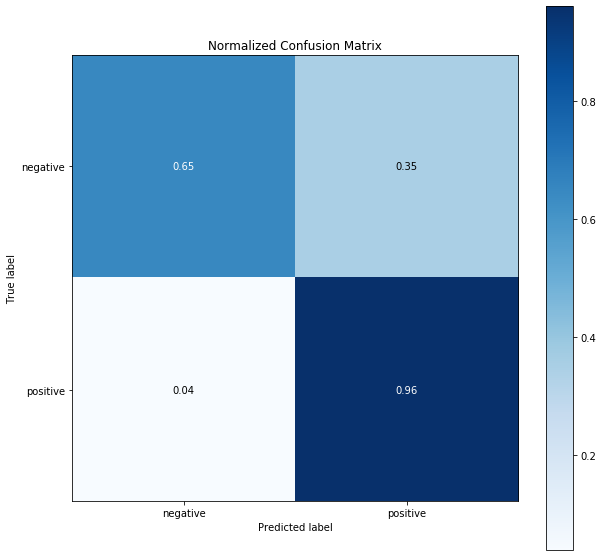

Confusion matrix on Sentiment140 corpus
Accuracy: 0.51774


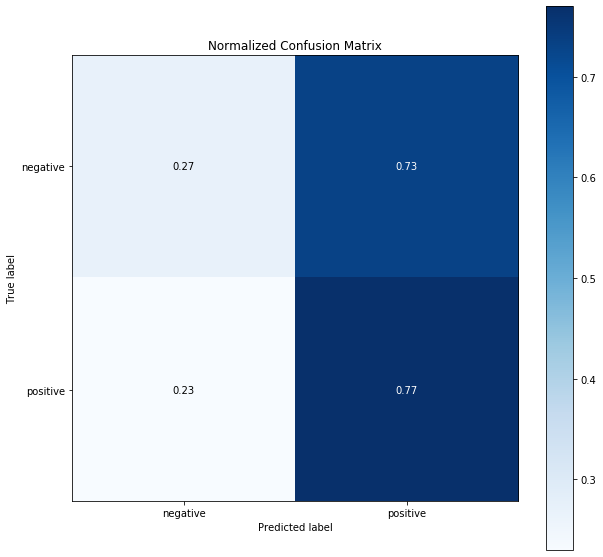

Confusion matrix on Movie Review corpus
Accuracy: 0.57404


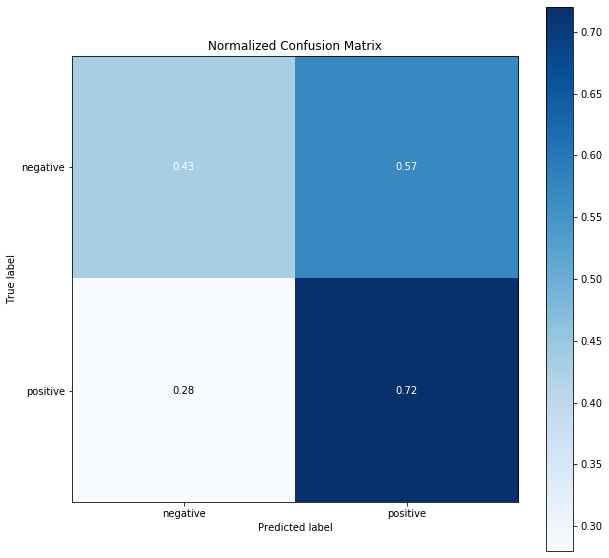

In [83]:
do(cc, [(s140, "Sentiment140"), (mr, "Movie Review")], "Climate Change", {'ngram': (1, 3), 'alpha': 0.1})

Model will be training on the Movie Review dataset
Creating model... ok
Training... ok
Confusion matrix on its validation set
Accuracy: 0.88840


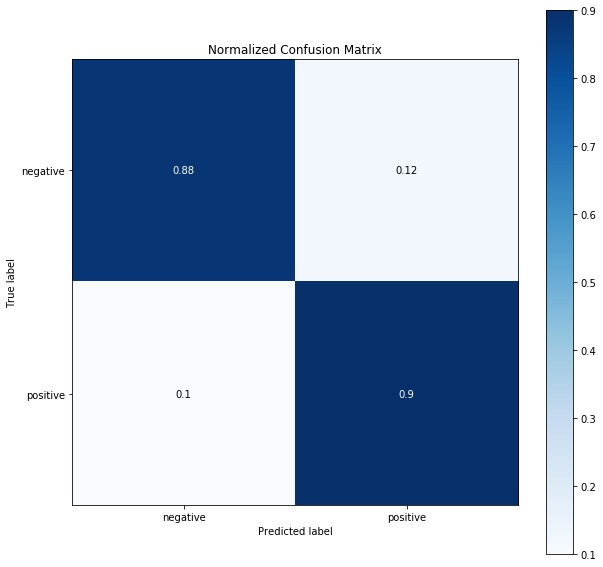

Confusion matrix on Climate Change corpus
Accuracy: 0.68331


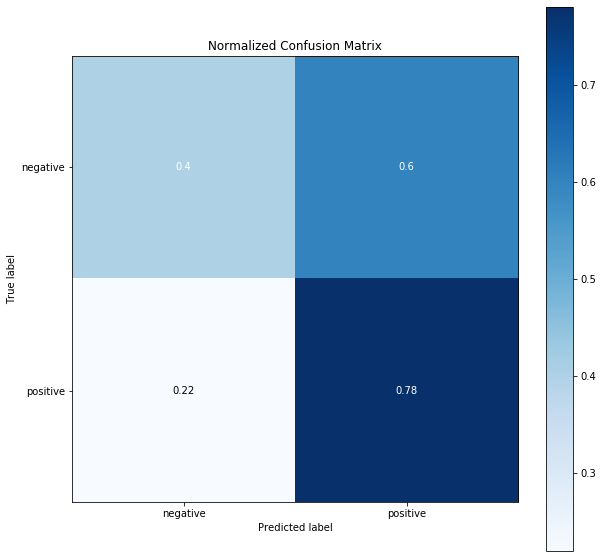

Confusion matrix on Sentiment 140 corpus
Accuracy: 0.59161


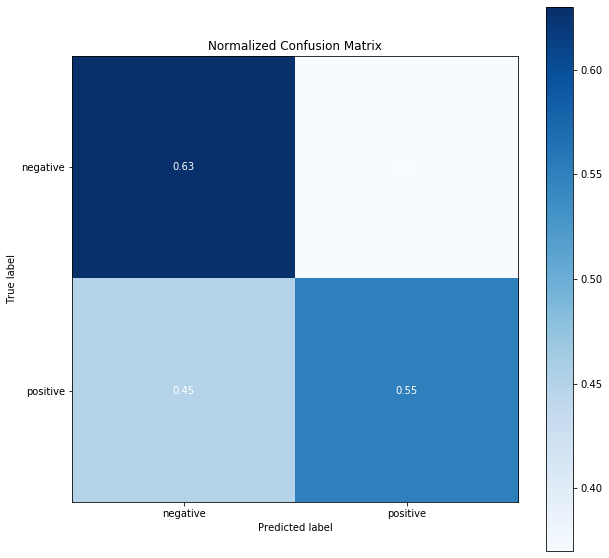

In [86]:
do(mr, [(cc, "Climate Change"), (s140, "Sentiment 140")], "Movie Review", {'ngram': (1, 3), 'alpha': 0.5})

Model will be training on the Sentiment140 dataset
Creating model... ok
Training... ok
Confusion matrix on its validation set
Accuracy: 0.76708


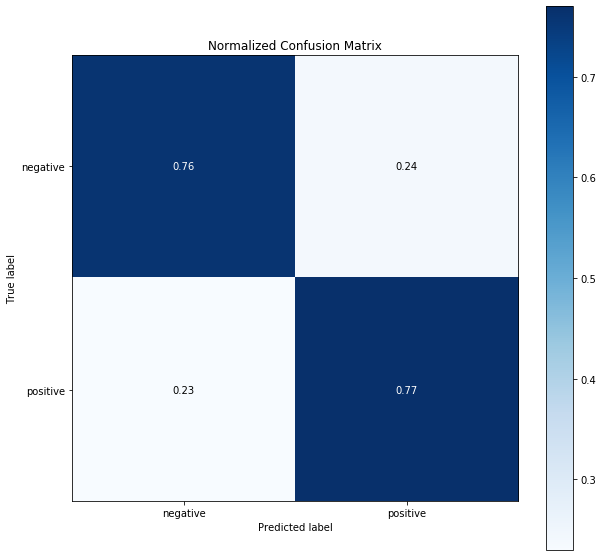

Confusion matrix on Climate Change corpus
Accuracy: 0.61906


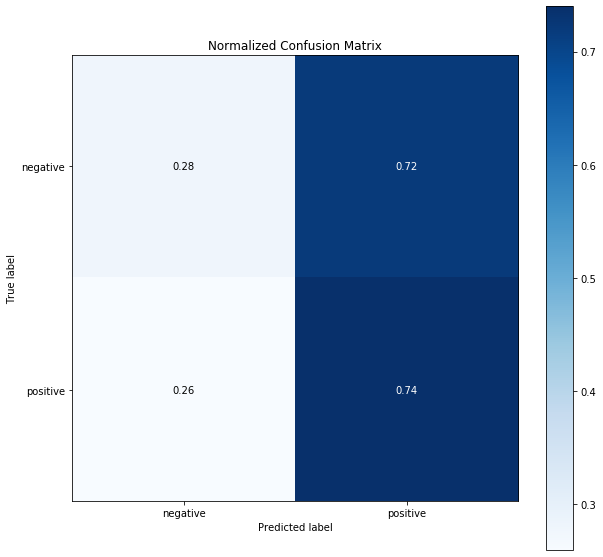

Confusion matrix on Movie Review corpus
Accuracy: 0.68070


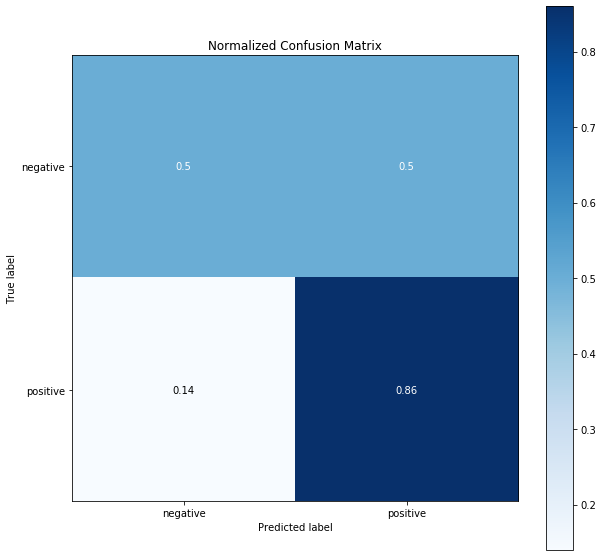

In [85]:
do(s140, [(cc, "Climate Change"), (mr, "Movie Review")], "Sentiment140", {'ngram': (1, 2), 'alpha': 0.9})